In [1]:

!nvidia-smi

Sun May 14 16:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [3]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.show()

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [7]:

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img,  ImageDataGenerator, img_to_array

In [8]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/CokeDataset"


train_dir = "/content/drive/MyDrive/Colab Notebooks/CokeDataset/Train"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/CokeDataset/Test"
categories = ['Coke','NoCoke']


In [10]:

batch_size = 32
img_height = 256
img_width = 256

In [11]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=True,
  )

train_ds = tf.keras.utils.image_dataset_from_directory(
   train_dir,
   labels = 'inferred',
   class_names = None,
   color_mode = 'rgb',
   batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=True,
)

Found 67 files belonging to 2 classes.
Found 124 files belonging to 2 classes.


In [12]:

class_names = train_ds.class_names
print(class_names)

['Coke', 'Nocoke']


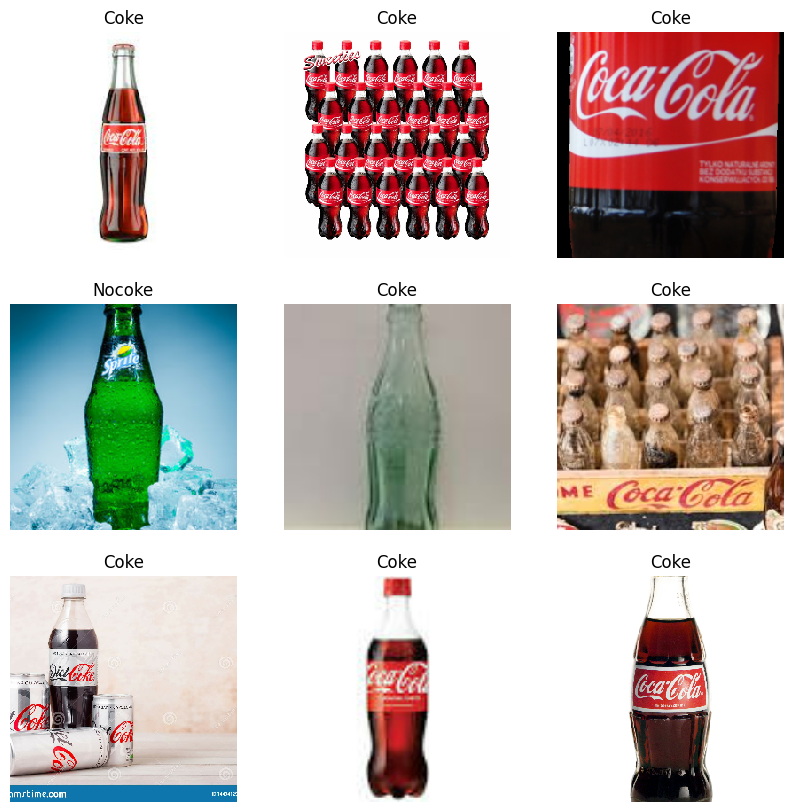

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
     

(32, 256, 256, 3)
(32,)


In [15]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
his = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [17]:

his_model = model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10
4/4 [==============================] - 58s 14s/step - loss: 3.1411 - accuracy: 0.7097 - val_loss: 0.7835 - val_accuracy: 0.5075
Epoch 2/10
4/4 [==============================] - 5s 417ms/step - loss: 0.7586 - accuracy: 0.4758 - val_loss: 0.6834 - val_accuracy: 0.5075
Epoch 3/10
4/4 [==============================] - 4s 400ms/step - loss: 0.6290 - accuracy: 0.7016 - val_loss: 0.6787 - val_accuracy: 0.5075
Epoch 4/10
4/4 [==============================] - 6s 408ms/step - loss: 0.5495 - accuracy: 0.7016 - val_loss: 0.7197 - val_accuracy: 0.5075
Epoch 5/10
4/4 [==============================] - 4s 557ms/step - loss: 0.4729 - accuracy: 0.7419 - val_loss: 0.5144 - val_accuracy: 0.7313
Epoch 6/10
4/4 [==============================] - 4s 425ms/step - loss: 0.3649 - accuracy: 0.8387 - val_loss: 0.5209 - val_accuracy: 0.7463
Epoch 7/10
4/4 [==============================] - 5s 398ms/step - loss: 0.2895 - accuracy: 0.9032 - val_loss: 0.2307 - val_accuracy: 0.9254
Epoch 8/10
4/4 [=====

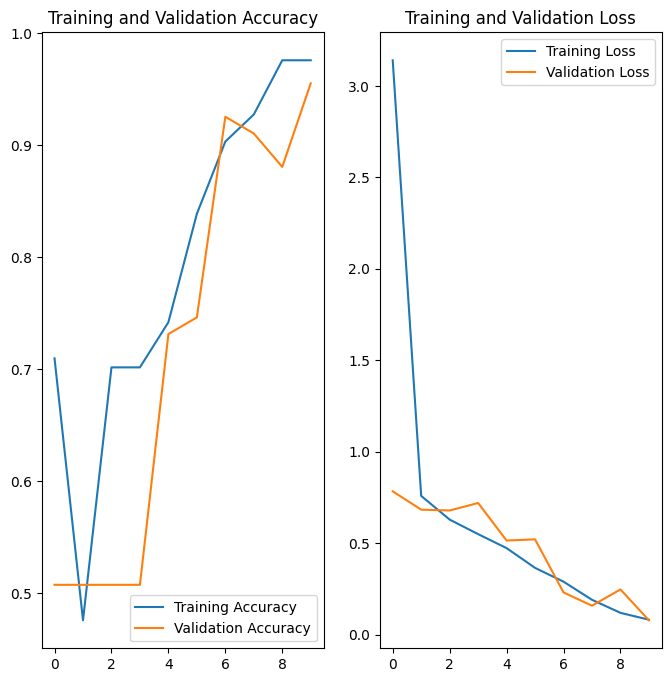

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

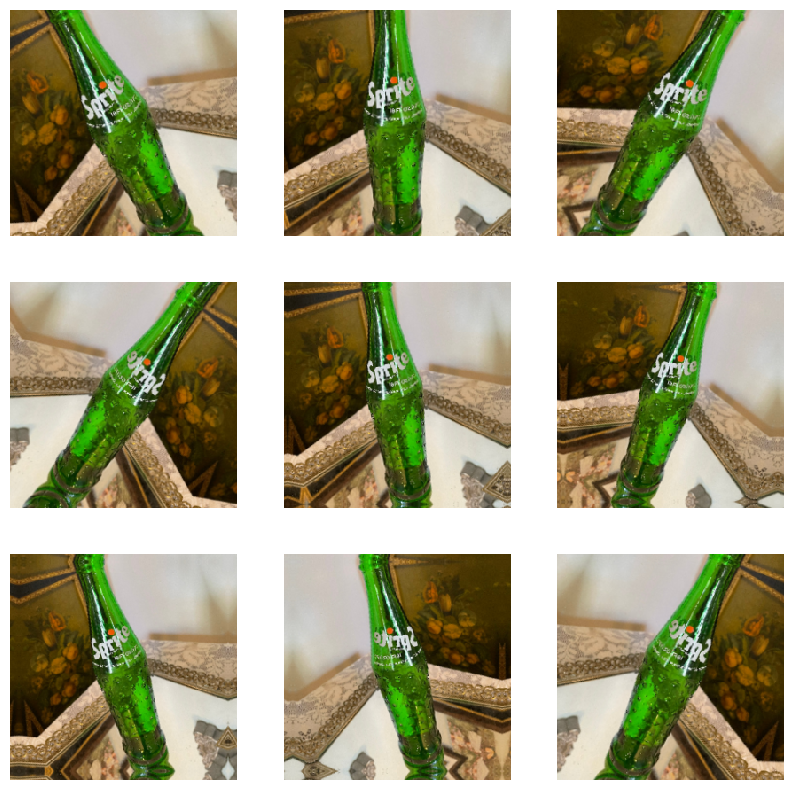

In [22]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [26]:

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
4/4 [==============================] - 8s 462ms/step - loss: 3.6098 - accuracy: 0.6290 - val_loss: 1.1164 - val_accuracy: 0.4925
Epoch 2/15
4/4 [==============================] - 5s 939ms/step - loss: 0.8371 - accuracy: 0.5403 - val_loss: 0.7673 - val_accuracy: 0.5075
Epoch 3/15
4/4 [==============================] - 6s 925ms/step - loss: 0.5617 - accuracy: 0.7016 - val_loss: 0.6372 - val_accuracy: 0.5522
Epoch 4/15
4/4 [==============================] - 4s 417ms/step - loss: 0.5043 - accuracy: 0.7823 - val_loss: 0.5257 - val_accuracy: 0.7015
Epoch 5/15
4/4 [==============================] - 4s 658ms/step - loss: 0.4095 - accuracy: 0.8065 - val_loss: 0.4083 - val_accuracy: 0.7761
Epoch 6/15
4/4 [==============================] - 4s 401ms/step - loss: 0.3409 - accuracy: 0.8629 - val_loss: 0.4204 - val_accuracy: 0.7761
Epoch 7/15
4/4 [==============================] - 4s 423ms/step - loss: 0.2896 - accuracy: 0.8548 - val_loss: 0.3967 - val_accuracy: 0.7761
Epoch 8/15
4/4 [====

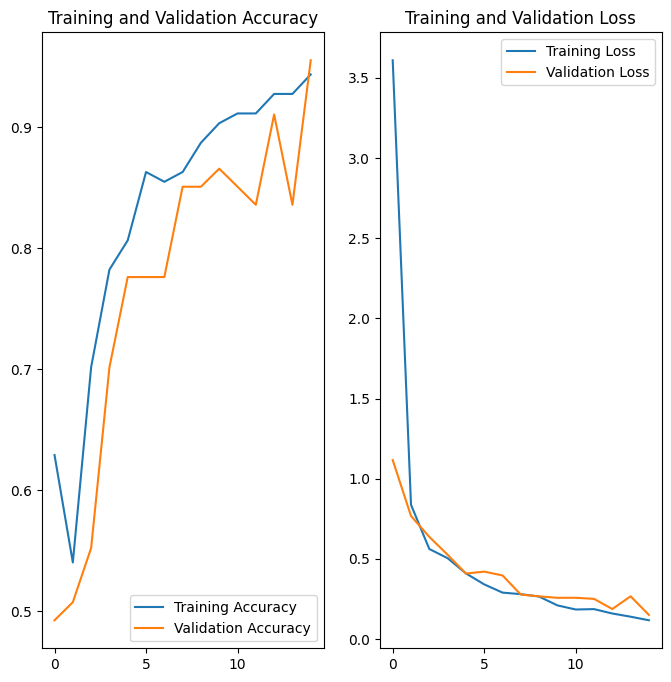

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Coke with a 99.92 percent confidence.


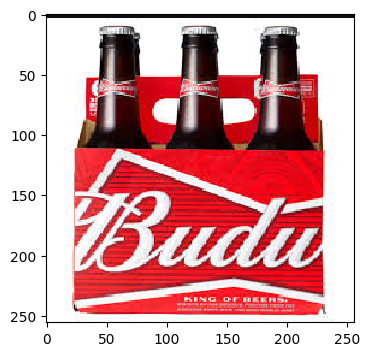

In [35]:
image = "/content/bud.png"

img = tf.keras.utils.load_img(
    image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print( "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.imshow(img)
     
